<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Design-notes" data-toc-modified-id="Design-notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Design notes</a></span><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Design" data-toc-modified-id="Design-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Design</a></span></li><li><span><a href="#Examples-of-sequence-functions" data-toc-modified-id="Examples-of-sequence-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Examples of sequence functions</a></span></li></ul></li><li><span><a href="#Seed-functions" data-toc-modified-id="Seed-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Seed functions</a></span><ul class="toc-item"><li><span><a href="#Seed-functions" data-toc-modified-id="Seed-functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Seed functions</a></span></li></ul></li><li><span><a href="#sequence-functions" data-toc-modified-id="sequence-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>sequence functions</a></span><ul class="toc-item"><li><span><a href="#categorical-maps" data-toc-modified-id="categorical-maps-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>categorical maps</a></span></li><li><span><a href="#Numerical" data-toc-modified-id="Numerical-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Numerical</a></span></li></ul></li><li><span><a href="#Scrap" data-toc-modified-id="Scrap-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scrap</a></span><ul class="toc-item"><li><span><a href="#target-functions" data-toc-modified-id="target-functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>target functions</a></span><ul class="toc-item"><li><span><a href="#Categorical-driven-annots-and-wf" data-toc-modified-id="Categorical-driven-annots-and-wf-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Categorical driven annots and wf</a></span></li></ul></li><li><span><a href="#An-example-of-generators" data-toc-modified-id="An-example-of-generators-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>An example of generators</a></span></li><li><span><a href="#Currying" data-toc-modified-id="Currying-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Currying</a></span></li><li><span><a href="#Some-dag-viz" data-toc-modified-id="Some-dag-viz-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Some dag viz</a></span></li></ul></li></ul></div>

In [ ]:

# frequently used builtins
import os
from collections import Counter, defaultdict

# frequently used data pkgs
import numpy as np
import pandas as pd
			
# careful import of matplotlib
try:
	import matplotlib.pyplot as plt
except ModuleNotFoundError as e:  # to catch ModuleNotFoundError: No module named '_tkinter'
	import matplotlib
	matplotlib.use('agg')
	import matplotlib.pyplot as plt

# some magic stuff
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Design notes

## Objective

This package offers tools for generating sequences. Finite ones like lists and arrays, or infinite ones like streams. 

The items of the sequences can be anything and often one sequence produced will be used to produce another (see further design notes). 
The target (i.e. final) sequence items would be samples of a signal (like sound, image, or other data from some sensor source) or typical time-series. 

For starters, our main focus will be generating sound -- that is, servicing the [hum](https://github.com/otosense/hum) package. 

Our main tools will be taken from [creek](https://github.com/i2mint/creek) and possibly [lined]()


## Design

Our running examples will be taken from audio production. 
We'll use `wf` to denote a waveform object (usually a list or array of numbers -- a.k.a. samples or frames). 

To get a waveform, you specify some `params` (including, say, the kind, 
or the actual function that the params should be called with to produce the result), 
and you get a waveform `wf`.

![image](https://user-images.githubusercontent.com/1906276/129167933-b1cdba31-0e8c-46b9-b789-c89732d06ce3.png)

This `wf` could be a fixed-size object like an array, or could be a source of unbounded amounts of data, 
like a generator, a stream object, a or a `creek.InfiniteSeq` which gives you the array-like ability to slice (i.e. `wf[i:j]`). 

The purpose of `slink` is to provide tools to get from params to this `wf`, or what ever the target sequence maybe. 
The main means of doing so is through a chain of sequences each one being a function of the previous. 
This function could do things like...


<img src="https://user-images.githubusercontent.com/1906276/129180811-c6f94159-8a9b-4f42-9f99-34607ade643d.png" alt="drawing" style="width:1200px"/>

<img src="https://user-images.githubusercontent.com/1906276/129182049-c6717da0-3251-4f1a-bf75-163c92db42da.png" alt="drawing" style="width:1200px"/>


```python
a, b, c... -> wf_for(a), wf_for(b), wf_for(c), ...  # generate elements of the next sequence based on the items of the last
wf_a, wf_b, wf_c... -> add_noise(wf_a), add_noise(wf_b), add_noise(wf_c), ... # transform the items of the last sequence
-> concatinate(wf_a_with_noise, ...)  # aggregate these items
-> chunk -> wf_chk_1, wf_chk_2, ...  # split these items
```

All but the last sequence functions above were all 
- `map` (applying the same function to each element of the input sequence) 
- `reduce` (aggregating all sequence items into one object -- though that object may be a sequence itself)

But some functions can have more complex mechanisms such as inner-state and buffers. 
This is important to note, since the developer may be tempted to accommodate for sequence functions that operate on a window instead of a single item. 
But accommodating for this directly would complexify the interface.
Instead, we propose to use a mechanism like `lined.BufferStats` to offer a window-input functionality with a single-item-at-a-time interface.

## Examples of sequence functions

For categoricals: Use the `__getitem__` of a mapping that relates each element of a finite set of seeds to a waveform, 
or parameters that will be used to produce the waveform:

```python
cat_map = {'a': [1,2,3], 'b': [4,5,6]}
item_func_1 = cat_map.__getitem__
# to make the sequence function from this item func, you can do:
from lined import iterize
seq_func_1 = iterize(item_func_1)
```

Could also use finite mappings like above for numericals by first using a function that will map to a categorical

```python
num_to_cat = lambda num: list(cat_map)[num % len(cat_map)]
from lined import iterize, Line
seq_func_2 = iterize(Line(num_to_cat, item_func_1))
```

`Line` composes `num_to_cat` and `item_func_1` and `iterize` makes the item-to-item function into a sequence-to-sequence function.



# Seed functions

Seed functions are the functions that produce the first sequence of the pipeline of sequence transformations. 

They're not the outer most layer: The outer-most layer contains the whole pipeline, and has as arguments any parameters that the steps of the pipeline might need. 

A seed functions is called repeatedly to produce either an item at a time (`n=1`), a chunk (`n>1`), or an iterable (`n=0`) that may or may not be a finite one. 

## Seed functions

In [123]:
import itertools
from slink.seed_functions import RandomCategoricalGenerator

r = RandomCategoricalGenerator()
it = r(None)
assert r() in r.categories # True or False
assert r(n=1) in r.categories # same as r()
result = r(n=3)
assert isinstance(result, list)  # e.g. [False, True, False]
r = RandomCategoricalGenerator(chunk_container=tuple)
result = r(n=3)
assert isinstance(result, tuple)  # e.g. (False, True, False)
list(itertools.islice(it, 0, 4)) # e.g. [False, False, False, True]

[False, False, True, True]

# sequence functions

In [127]:
import itertools
from functools import partial

import numpy as np
from lined import iterize, Line, LineParametrized

## categorical maps

In [122]:
cat_map = {'a': [1,2,3], 'b': [4,5,6]}
get_list_for_cat = cat_map.__getitem__

# to make the sequence function from this item func, you can do:
iterized_get_list_for_cat = iterize(get_list_for_cat)
assert list(iterized_get_list_for_cat('abaa')) == [[1, 2, 3], [4, 5, 6], [1, 2, 3], [1, 2, 3]]

In [146]:
def get_list_for_cat(category):
    return cat_map[category]

seed_gen = RandomCategoricalGenerator(categories='ab')

g = Line(
    seed_gen,
    iterize(get_list_for_cat),
    list,
    lambda x: x
)
g(n=5)

[[4, 5, 6], [1, 2, 3], [1, 2, 3], [4, 5, 6], [4, 5, 6]]

In [149]:
cat_2_parms_map = {
    'a': dict(loc=5, scale=0.5, size=3),
    'b': dict(loc=10, scale=0.3, size=2),
}
get_params_for_cat = cat_2_parms_map.__getitem__
call_normal_rand_on_params = lambda params: np.random.normal(**params)

_cat_based_chunk_gen = Line(
    get_params_for_cat,  # get some params for a category
    call_normal_rand_on_params,  # draw from a normal distribution with those params
    iterize(int),  # cast the result to an int
    list  # make the arrays into lists (because it's nicer for display)
)
cat_based_chunk_gen = iterize(_cat_based_chunk_gen)
list(cat_based_chunk_gen('abaa'))

[[4, 5, 5], [9, 10], [5, 4, 4], [4, 5, 4]]

In [86]:
#_cat_based_chunk_gen.dot_digraph()  # to make that work, need to make get_params_for_cat a function with signature

In [154]:
cat_2_parms_map = {
    'a': dict(loc=5, scale=0.5, size=3),
    'b': dict(loc=10, scale=0.3, size=2),
}

def get_params_for_cat(category):
    return cat_2_parms_map[category]

def call_normal_rand_on_params(params):
    return np.random.normal(**params)


_cat_based_chunk_gen = Line(
    get_params_for_cat,  # get some params for a category
    call_normal_rand_on_params,  # draw from a normal distribution with those params
    iterize(int),  # cast the result to an int
    list  # make the arrays into lists (because it's nicer for display)
)
cat_based_chunk_gen = iterize(_cat_based_chunk_gen)
list(cat_based_chunk_gen('abaa'))

[[4, 5, 4], [9, 10], [5, 5, 4], [5, 5, 5]]

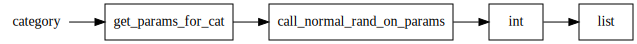

In [155]:
_cat_based_chunk_gen.dot_digraph()

## Numerical

In [203]:
# TODO: Replace norm_offset and norm_scale by a num normalizing function
# TODO: Give control over spectr normalization
def get_spectr_from_number(num, spectr, norm_offset, norm_scale):
    """
    This function is meant to be curried so that only num is left.
    - spectr is meant to be fixed for a given dimension of data (where the nums are coming from)
    - 
    """
    spectr = np.array(spectr)
    normalized_num = (num - norm_offset) / norm_scale
    original_spectr_sum = sum(spectr)
    spectr = spectr + normalized_num  # shift spectr by normalized_num
    factor_to_conserve_sum = original_spectr_sum / sum(spectr)
    return spectr * factor_to_conserve_sum


list_of_ints = Line(
    iterize(int),
    list,
)

lists_of_list_of_ints = Line(
    iterize(list_of_ints),
    list,
)


get_params_from_number(10, [1, 2, 3], 2, 5)

array([1.44444444, 2.        , 2.55555556])

In [204]:
_num_based_wf_gen = LineParametrized(
    ('get_spectr', partial(get_spectr_from_number, spectr=[400, 900, 50], norm_offset=2, norm_scale=10)), 
    ('wf_to_spectr', np.fft.rfft),
    ('normalize_rfft', lambda rfft_wf: np.abs(rfft_wf)),
)

list_of_ints(_num_based_wf_gen(10000))

[1350, 229]

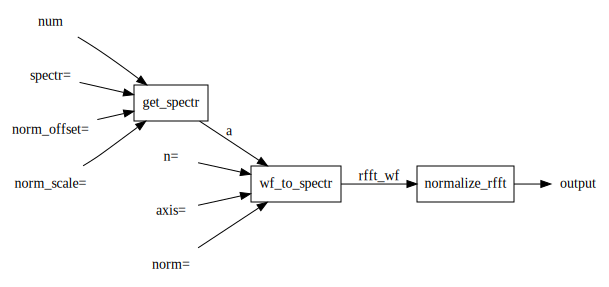

In [205]:
_num_based_wf_gen.dot_digraph()

In [207]:
num_based_wf_gen = iterize(_num_based_wf_gen)
lists_of_list_of_ints(num_based_wf_gen([4, 10000, 70]))

[[1350, 739], [1350, 229], [1350, 728]]

# Scrap

## target functions

In [61]:
def datagen():
    """What ever the default data gen is -- controllable through module/system configs"""


# which really comes from a totally defaulted function controlled by a `kind` argument:
obj_of_kind = dict()  # Mapping[str, Callable]
DFLT_KIND = 'wf'

def _kind_to_obj(kind):
    if isinstance(kind, str):
        return obj_of_kind[kind]
    return kind


def datagen(kind=DFLT_KIND, **kwargs):
    """Provides data of the given kind, controlled by kwargs parameters"""
    obj = _kind_to_obj(kind)
    return obj(**kwargs)


# can some kwargs be shared by all?

def datagen(kind=DFLT_KIND, n_items=None, **kwargs):
    """if n_items is an int, will yield that many items -- if not will be an infinite generator"""

    
# forged/him
from numbers import Number
from typing import Union, Tuple, Dict, Any, Callable
Num = Union[float, int]

Categories = Union[int, Tuple[str], Dict[str, Number]]
Category = str

# CategoriesWithROW = Optional[Categories]

def categorized_wf_and_annots(
    categories: Categories=('cat', 'dog'),  # int, list of cateogories, {cat: weight, ...} dict, 
    coverage=0.1,
#     tag_for_not_tagged: str = 'row',
    include_not_tagged_as_tag: bool = True
#     add_rest_of_world: bool, 
):
    # wf_store: Mapping[Key, Wf], annots: Iterable[annotation_item]
    return wf_store, annot_store  


from lined import Line

iter_to_dict = Line(enumerate, dict)



def _ensure_categories(categories: Categories):
    if isinstance(categories, int):
        n_categories = categories
        list('abcdefghijklmnopqrstuvwxyz'[:n_categories])
    if not isinstance(categories, dict):
        categories = {category: 1 for category in categories}
    total_weight = sum(categories.values())
    return {category: weight / total_weight for category, weight in categories.items()}

# TODO: Use frozendict or add [(k, v), ...] to dict in the above
Waveform = Any
BT = Num
TT = Num
TaggedSegmentArgs = [Category, BT, TT]
Annot = Any


def single_wf_full_coverage_truth(
    cat_bt_tt_to_wf: Callable[TaggedSegmentArgs, Waveform], 
    cat_bt_tt_to_annot: Callable[TaggedSegmentArgs, Annot],
    categories: Categories=('cat', 'dog', '_something_else'),
    # group and aggreg func for wf?
):
    categories = _ensure_categories(categories)
    # make iterable of cat_bt_tt
    # make wf_store from it using cat_bt_tt_to_wf
    # make annot_store from it using cat_bt_tt_to_annot
    # wf_store: Mapping[Key, Wf], annots: Iterable[annotation_item]
    return wf, annots

def multiple_wf_full_coverage_truth(
):
    """returns wf_store and annots_store"""
    

In [55]:
full_coverage_truth()

{'cat': 0.3333333333333333,
 'dog': 0.3333333333333333,
 '_something_else': 0.3333333333333333}

In [50]:
''.join(map(chr, range(97, 123)))

'abcdefghijklmnopqrstuvwxyz'

('cat', 'dog') --> everything covered by cats xor dogs

('cat', 'dog') --> everything covered by cats xor dogs xor nothing

('cat', 'dog', 'not_tagged')

---******____________--______***


In [ ]:
full_coverage_truth({'cat': 1, 'dog': 2, '_something_else': 17})


full_coverage_truth({'cat': 1, 'dog'a


In [45]:
t = [12,22,30]
tt = iter_to_dict(t)
tt

{0: 12, 1: 22, 2: 30}

In [35]:
not_tagged = NotTaggedTag()
not_tagged == '_not_tagged'

False

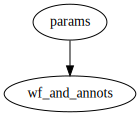

In [4]:
from ut import dgdisp

dgdisp("""
params -> wf_and_annots
""")

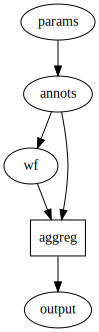

In [7]:
dgdisp("""
params -> annots
annots -> wf
annots, wf -> [aggreg] -> output
""")

In [ ]:
(bt, tt, parms)


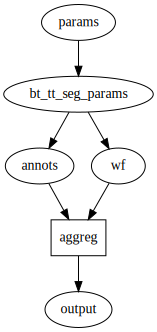

In [10]:
dgdisp("""
params -> bt_tt_seg_params
bt_tt_seg_params -> annots, wf
annots, wf -> [aggreg] -> output
""")

In [ ]:
wf = wf_func(bt, tt, **fixed_params)

wf = mk_wf_interface(**fixed_params)
# wf.__getitem__
wf[bt:tt]

In [ ]:
def mk_wf_func_from_array(wf_array):
    def wf_func(bt, tt):
        return wf_array[bt:tt]
    return wf_func

In [ ]:
annots : cat dog
wf_func(bt, tt):
    --> 

In [223]:
# import sklearn
#AttributeError: module 'numpy.linalg' has no attribute 'lapack_lite'

### Categorical driven annots and wf

Figure out how to generate/handle:
- rest-of-the-world tags
- wrong annotations (think FP: said cat but was a dog... or nothing)
- missing tags (think FN: wf has a cat but I don't see it in annotation)


Possible framework:
- categories



Theme questions:
- what are the arguments that might be common to all (or almost all) generators? e.g. n_items

## An example of generators

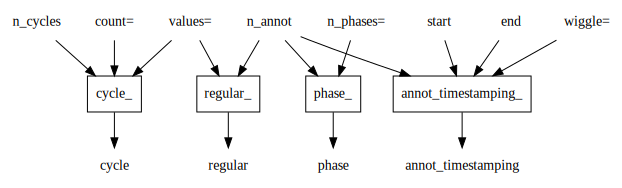

In [213]:
from lined import LineParametrized
import qcoto.tests.synthetic_data as sd
from meshed import DAG

dag = DAG([
    sd.annot_timestamping, 
#     sd.rpm, 
    sd.phase, 
    sd.cycle, 
    sd.regular
])
dag.dot_digraph()

In [214]:
dag(n_cycles=7,
    n_annot=7,
    start=0,
    end=int(1e6))

(['a', 'a', 'a', 'b', 'b', 'b'],
 [0.0,
  166566.66666666666,
  333251.3333333333,
  500012.0,
  666609.6666666666,
  833291.3333333333,
  1000000.0],
 ['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b'],
 [0, 1, 2, 3, 4])

## Currying

In [59]:
from functools import partial, wraps

class Curryer:
    def __init__(self, func):
        self.func = func
        try:
            wraps(func)(self)  # TODO: copy all attrs, or just signature, using functools.update_wrapper?
        except:
            pass

    def __call__(self, *args, **kwargs):
        return partial(self.func, *args, **kwargs)
    
import random
randint_curryer = Curryer(random.randint)

# What you do with it is this (what you do with partial, but with the function fixed)
get_randint = randint_curryer(2, 4)
assert get_randint() in {2, 3, 4}

# But the real point of using Curryer is that the curryer has the same docs and signature as the function 
# that is being curried, so it's easier to choose the arguments you're binding
from inspect import signature
assert signature(randint_curryer) == signature(random.randint)
assert randint_curryer.__doc__ == random.randint.__doc__

import pandas as pd
data_frame_curryer = Curryer(pd.DataFrame)

df_maker = data_frame_curryer(columns=['earth', 'and', 'fire'])
df_maker([(1, 2, 3), (4, 5, 6)])

from inspect import signature
assert signature(data_frame_curryer) == signature(pd.DataFrame)
assert data_frame_curryer.__doc__ == pd.DataFrame.__doc__

## Some dag viz

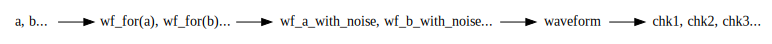

In [14]:
from ut import dgdisp

dgdisp("""
rankdir=LR
categories -> wfs_for_each_category -> transformed_wf_for_each_category -> concatinate -> chunk
categories [label="a, b..." shape=none]
wfs_for_each_category [label="wf_for(a), wf_for(b)..." shape=none]
transformed_wf_for_each_category [label="wf_a_with_noise, wf_b_with_noise..." shape=none]
concatinate [label="waveform" shape=none]
chunk [label="chk1, chk2, chk3..." shape=none]
""")